In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report)

In [ ]:
# 1. Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)  # 0 = malignant, 1 = benign
print("Shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Shape: (569, 30)
Target distribution:
 1    357
0    212
Name: count, dtype: int64


In [ ]:
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=42, stratify=y
)

In [ ]:
# 3. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 4. Baseline models
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print("Baseline RF Accuracy:", accuracy_score(y_test,
y_pred_rf))

svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
print("Baseline SVM Accuracy:", accuracy_score(y_test,
y_pred_svm))

Baseline RF Accuracy: 0.956140350877193
Baseline SVM Accuracy: 0.9824561403508771


In [ ]:
# 5. Cross-validation (Stratified K-Fold)
cv = StratifiedKFold(n_splits=5, shuffle=True,
random_state=42)
rf_cv_scores = cross_val_score(rf, X_train_scaled, y_train,
cv=cv, scoring='accuracy')
svm_cv_scores = cross_val_score(svm, X_train_scaled, y_train,
cv=cv, scoring='accuracy')
print("RF CV Mean Accuracy:", rf_cv_scores.mean())
print("SVM CV Mean Accuracy:", svm_cv_scores.mean())

RF CV Mean Accuracy: 0.9626373626373628
SVM CV Mean Accuracy: 0.9670329670329672


In [ ]:
# 6. Hyperparameter tuning - Random Forest (GridSearchCV)
rf_param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 5, 10, 20],
'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
print("Best RF params:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# 7. Hyperparameter tuning - SVM (RandomizedSearchCV)
svm_param_dist = { 'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly'] }
svm_rand = RandomizedSearchCV(SVC(probability=True,
random_state=42),
svm_param_dist, n_iter=8, cv=cv,
scoring='accuracy', n_jobs=-1, random_state=42)
svm_rand.fit(X_train_scaled, y_train)
print("Best SVM params:", svm_rand.best_params_)
best_svm = svm_rand.best_estimator_

Best SVM params: {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


In [ ]:
# 8. Evaluation function
def eval_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1]
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_prob)
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))
  print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {auc:.4f}")
  return y_prob, y_pred

In [ ]:
# 9. Evaluate tuned models on test set
print("----- Evaluating Best Random Forest -----")
rf_probs, rf_preds = eval_model(best_rf, X_test_scaled, y_test)
print("----- Evaluating Best SVM -----")
svm_probs, svm_preds = eval_model(best_svm, X_test_scaled, y_test)

----- Evaluating Best Random Forest -----
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix:
[[39  3]
 [ 2 70]]
Accuracy: 0.9561, Precision: 0.9589, Recall: 0.9722, F1: 0.9655, ROC-AUC: 0.9939
----- Evaluating Best SVM -----
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion Matrix:
[[41  1]
 [ 1 71]]
Accuracy: 0.9825, Precision: 0.9861, Recall: 0.9861, F1: 0.9861, ROC-AUC: 0.9957


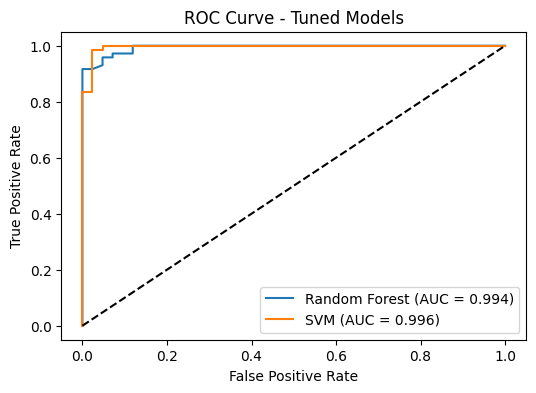

In [ ]:
# 10. Plot ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_probs):.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_score(y_test, svm_probs):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Models')
plt.legend()
plt.show()

Both Random Forest (AUC = 0.994) and SVM (AUC = 0.996) models demonstrated excellent performance in classifying breast cancer. The SVM model achieved a slightly higher AUC, indicating marginally better overall discriminatory power on this dataset.